# Machine Learning

## Set up

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load data
df = pd.read_pickle("sample")
# show numerical values
df.describe()

,backers_count,goal,pledged,life,duration,prep
count,231381.000000,2.313810e+05,2.313810e+05,231381,231381,231381
mean,134.295772,4.729175e+04,1.227821e+04,33 days 20:09:57.300962,31 days 10:05:47.950847,42 days 21:29:37.516438
std,1095.131066,1.172776e+06,1.320999e+05,12 days 13:00:42.671194,14 days 07:00:24.493691,110 days 13:02:43.664584
min,0.000000,1.000000e-02,0.000000e+00,1 days 00:00:00,0 days 00:00:00,0 days 00:01:41
25%,2.000000,2.000000e+03,5.000000e+01,30 days 00:00:00,28 days 13:07:40,2 days 17:09:51
50%,19.000000,5.000000e+03,1.035000e+03,30 days 00:00:00,30 days 00:00:01,10 days 01:52:47
75%,74.000000,1.500000e+04,5.405420e+03,35 days 22:27:34,34 days 18:48:37,34 days 10:33:15
max,219382.000000,1.000000e+08,2.902191e+07,91 days 23:00:00,354 days 19:06:23,2313 days 16:40:37


In [3]:
# convert duration data to seconds
df['life_days'] = df['life'].dt.days
df['prep_days'] = df['prep'].dt.days

In [4]:
# keep only successful / fail projects
# keep only US projects
data = df[(df.location_country =="US") & ((df.state == "successful")|(df.state == "failed"))].reset_index(drop = True)

# keep only numerical/categorical variables
DropCol = ['location_country','location_state','location_localized_name','location_name','cbsa_name','creator_name',
      'category_name','launched_at','deadline','state_changed_at','life','duration','prep']

data = data.drop(DropCol,axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159925 entries, 0 to 159924
Data columns (total 10 columns):
top100            156804 non-null object
backers_count     159925 non-null int64
goal              159925 non-null float64
pledged           159925 non-null float64
gender            159925 non-null object
category_broad    159925 non-null category
state             159925 non-null category
slug              159925 non-null object
life_days         159925 non-null int64
prep_days         159925 non-null int64
dtypes: category(2), float64(2), int64(3), object(3)
memory usage: 10.1+ MB


## Text Analysis 
Structure analysis of headline. Reference: http://nbviewer.jupyter.org/github/AYLIEN/headline_analysis/blob/06f1223012d285412a650c201a19a1c95859dca1/main-chunks.ipynb#A-primer-on-parse-trees

In [95]:
import spacy 
from spacy import displacy
import difflib

EN = spacy.load("en")
nlp = spacy.load('en_core_web_sm')

In [59]:
# test tokens
data.slug.sample(5)

78885            ragnarokkr-metal-apocalypse-2014
45970        a-kat-perkins-christmas-album-vol-ii
142673    athletic-shorts-city-of-trees-pre-order
72822                        muzic-the-great-food
7435                          the-presidents-book
Name: slug, dtype: object

In [90]:
def tokenize_text(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d slugs." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.pos_ for tok in doc]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

In [96]:
# tokenize all slugs.
slugs = [slug for slug in data['slug']]
slugs_tokenize = tokenize_text(slugs, True)

In [101]:
slugs_tokenize.sample(5)
slugs_tokenize.to_pickle("slugs_tokenize")

In [100]:
# difference in length and structure sequence
difflib.SequenceMatcher(None,slugs_tokenize[10],slugs_tokenize[2]).ratio()


0.6216216216216216

### Select a random sample randomly to train the classifier
Pair-wise similarity matrix for the headlines

In [152]:
# 500 training set
np.random.seed(500)

m = np.zeros((500,500))
for i, slug_x in enumerate(slugs_tokenize.sample(500)):
    for j, slug_y in enumerate(slug_x):
        m[i][j] = difflib.SequenceMatcher(None,slug_x,slug_y).ratio()

In [153]:
m.shape

(500, 500)

use tSNE to reduce the dimensionality of similarity matrix from 700 down to 2:

In [110]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0)

In [154]:
tsne = tsne_model.fit_transform(m)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.006s...
[t-SNE] Computed neighbors for 500 samples in 0.189s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.507072
[t-SNE] Error after 1000 iterations: 0.030532


In [162]:
from sklearn.cluster import MiniBatchKMeans

kmeans_model = MiniBatchKMeans(n_clusters=4, init='k-means++', n_init=1, 
                         init_size=1000, batch_size=1000, verbose=False, max_iter=1000)
kmeans = kmeans_model.fit(m)
kmeans_clusters = kmeans.predict(m)
kmeans_distances = kmeans.transform(m)

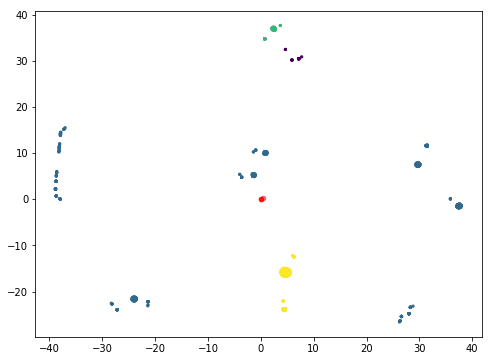

In [164]:
plt.figure(figsize=(8,6))

plt.scatter(tsne[:, 0], tsne[:, 1], c=kmeans_clusters, s=5, cmap='viridis' )
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200,  alpha=0.5)


## Scaling and normalization

,backers_count,goal,pledged,life_days,prep_days
backers_count,1.000000,0.007153,0.737697,0.002671,0.020596
goal,0.007153,1.000000,0.007825,0.022907,0.002539
pledged,0.737697,0.007825,1.000000,0.011743,0.019450
life_days,0.002671,0.022907,0.011743,1.000000,0.008228
prep_days,0.020596,0.002539,0.019450,0.008228,1.000000


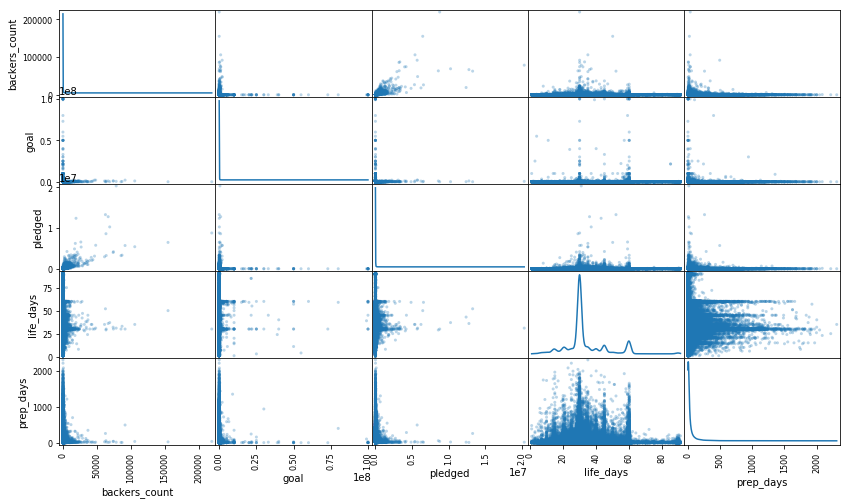

In [61]:
# Produce a scatter matrix for each pair of features in the data
pd.plotting.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');
data.corr()

In [25]:
NumCol = ['backers_count','goal','pledged','life_days','prep_days']
data[NumCol] = np.log(data[NumCol]+1)

In [ ]:
pd.plotting.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');
data.corr()

,backers_count,goal,pledged,life_days,prep_days
backers_count,1.000000,0.139108,0.933208,-0.009753,0.289139
goal,0.139108,1.000000,0.137127,0.229533,0.215374
pledged,0.933208,0.137127,1.000000,-0.000335,0.289492
life_days,-0.009753,0.229533,-0.000335,1.000000,0.050649
prep_days,0.289139,0.215374,0.289492,0.050649,1.000000


## Remove Outliers

In [93]:
import collections
c = collections.Counter()

for feature in NumCol:
    
    Q1 = np.percentile(data[feature], 25)
    Q3 = np.percentile(data[feature], 75)
    
    step = 1.5 * (Q3 - Q1)
    
    outlier = data[(~(data[feature] >= Q1 - step) & (data[feature] <= Q3 + step))]
    
    c.update(outlier.index)

In [94]:
outliers = []

# remove projects that have at least 2 outlier features

for ind,num in c.items(): 
    if num >= 2:
        outliers.append(ind)
        
len(outliers)/len(data)

0.005758949507581679

In [95]:
good_data = data.drop(data.index[outliers]).reset_index(drop = True)

In [96]:
good_data.describe()

,backers_count,goal,pledged,life,duration,prep,life_days,prep_days
count,159004.000000,159004.000000,159004.000000,159004,159004,159004,159004.000000,159004.000000
mean,3.076558,8.515938,6.432152,33 days 18:34:34.901706,33 days 18:35:06.126569,44 days 21:18:53.851054,3.479441,2.473131
std,1.915631,1.588539,3.201484,12 days 12:21:35.584738,12 days 12:21:53.846979,115 days 12:43:17.438079,0.367221,1.620649
min,0.000000,0.693147,0.000000,1 days 00:00:00,1 days 00:00:00,0 days 00:02:52,0.693147,0.000000
25%,1.386294,7.601402,4.615121,30 days 00:00:00,30 days 00:00:00,3 days 00:06:33.500000,3.433987,1.386294
50%,3.218876,8.517393,7.273786,30 days 00:00:00,30 days 00:00:01,11 days 00:09:41,3.433987,2.484907
75%,4.430817,9.472782,8.715880,35 days 08:33:51.750000,35 days 08:37:42.750000,35 days 15:43:59,3.583519,3.583519
max,12.298574,18.420681,16.828050,91 days 23:00:00,91 days 23:00:18,2313 days 16:40:37,4.521789,7.746733


## One-hot-encoding categorical variables

In [98]:
cat = ['gender','top100', 'category_broad']
data_dummies = pd.get_dummies(data, columns = cat)
data_dummies.describe()

,backers_count,goal,pledged,life,duration,prep,life_days,prep_days,gender_andy,gender_female,...,category_broad_fashion,category_broad_film & video,category_broad_food,category_broad_games,category_broad_journalism,category_broad_music,category_broad_photography,category_broad_publishing,category_broad_technology,category_broad_theater
count,159925.000000,159925.000000,159925.000000,159925,159925,159925,159925.000000,159925.000000,159925.000000,159925.000000,...,159925.000000,159925.000000,159925.000000,159925.00000,159925.000000,159925.000000,159925.000000,159925.000000,159925.000000,159925.000000
mean,3.071823,8.488673,6.422062,33 days 15:43:38.438561,33 days 15:44:09.554090,44 days 18:15:56.642801,3.473913,2.467488,0.010073,0.176970,...,0.044877,0.159362,0.070421,0.07411,0.016752,0.166816,0.024668,0.127103,0.082708,0.028395
std,1.914103,1.626298,3.199916,12 days 14:00:18.678735,12 days 14:00:36.900525,115 days 09:12:26.552228,0.375484,1.621652,0.099860,0.381645,...,0.207035,0.366015,0.255855,0.26195,0.128340,0.372812,0.155111,0.333090,0.275440,0.166098
min,0.000000,0.009950,0.000000,1 days 00:00:00,1 days 00:00:00,0 days 00:02:52,0.693147,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.386294,7.601402,4.615121,30 days 00:00:00,30 days 00:00:00,2 days 23:39:01,3.433987,1.098612,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.218876,8.517393,7.252762,30 days 00:00:00,30 days 00:00:01,10 days 22:54:38,3.433987,2.397895,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.430817,9.472782,8.709795,35 days 05:07:06,35 days 05:07:34,35 days 10:20:15,3.583519,3.583519,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,12.298574,18.420681,16.828050,91 days 23:00:00,91 days 23:00:18,2313 days 16:40:37,4.521789,7.746733,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
